In [37]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
from keras.metrics import MeanIoU, Accuracy

In [38]:
# unzip 2d images of lung CT
path = '2d_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_images')
    
# unzip 2d masks of lung CT
path = '2d_masks.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('2d_masks')

In [39]:
# load tiff images
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


In [40]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [41]:
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    y_data[i] = img

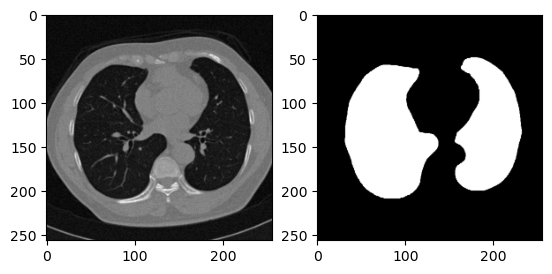

In [42]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[50].squeeze(), cmap='gray')
ax[1].imshow(y_data[50].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [43]:
# split dataset into train and validation datasets with 20% test portion
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(213, 256, 256, 1)
(54, 256, 256, 1)


In [44]:
def attention_block(input_encoder, input_decoder, filters):
    # Attention mechanism
    g = Conv2D(filters, (1, 1), activation='relu')(input_encoder)
    x = Conv2D(filters, (1, 1), activation='relu')(input_decoder)
    attn = Concatenate(axis=-1)([g, x])
    attn = Conv2D(filters, (1, 1), activation='relu')(attn)
    attn = Conv2D(1, (1, 1), activation='sigmoid')(attn)

    # Apply attention to decoder feature maps
    attn_decoder = Multiply()([attn, input_decoder])

    return attn_decoder

def attention_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting path (Encoder)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck layer
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Expansive path (Decoder)
    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    attn_decoder = attention_block(conv4, conv6, 256)

    up2 = UpSampling2D(size=(2, 2))(attn_decoder)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    attn_decoder2 = attention_block(conv3, conv7, 128)

    up3 = UpSampling2D(size=(2, 2))(attn_decoder2)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Example usage
input_shape = (256, 256, 1)

model = attention_unet(input_shape)

# Compile the model with sparse categorical crossentropy
opt = Adam(learning_rate=0.0001)
weights = [1, 10]
model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 256, 256, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_81[0][0]']              
                                )                                                           

                                                                                                  
 up_sampling2d_14 (UpSampling2D  (None, 128, 128, 12  0          ['multiply_7[0][0]']             
 )                              8)                                                                
                                                                                                  
 conv2d_103 (Conv2D)            (None, 128, 128, 64  73792       ['up_sampling2d_14[0][0]']       
                                )                                                                 
                                                                                                  
 conv2d_104 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_103[0][0]']             
                                )                                                                 
                                                                                                  
 up_sampli

In [46]:
#train model
model_checkpoint = ModelCheckpoint('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/att_unet_1.h5', monitor='loss', save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=4, callbacks=[model_checkpoint, callback])

Epoch 1/10
54/54 [==============================] - 202s 4s/step - loss: 0.0685 - accuracy: 0.9536
Epoch 2/10
54/54 [==============================] - 189s 4s/step - loss: 0.0757 - accuracy: 0.9535
Epoch 3/10
54/54 [==============================] - 198s 4s/step - loss: 0.0678 - accuracy: 0.9545
Epoch 4/10
54/54 [==============================] - 187s 3s/step - loss: 0.0908 - accuracy: 0.9522
Epoch 5/10
54/54 [==============================] - 181s 3s/step - loss: 0.0658 - accuracy: 0.9543
Epoch 6/10
54/54 [==============================] - 195s 4s/step - loss: 0.0566 - accuracy: 0.9556
Epoch 7/10
54/54 [==============================] - 181s 3s/step - loss: 0.0590 - accuracy: 0.9557
Epoch 8/10
54/54 [==============================] - 192s 4s/step - loss: 0.0540 - accuracy: 0.9558
Epoch 9/10
54/54 [==============================] - 195s 4s/step - loss: 0.0517 - accuracy: 0.9561
Epoch 10/10
54/54 [==============================] - 169s 3s/step - loss: 0.0596 - accuracy: 0.9557


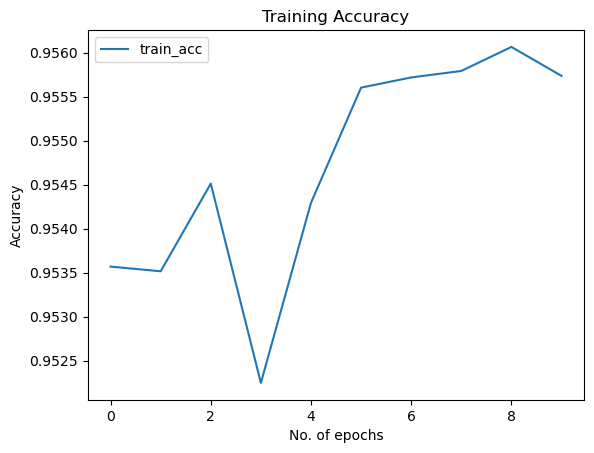

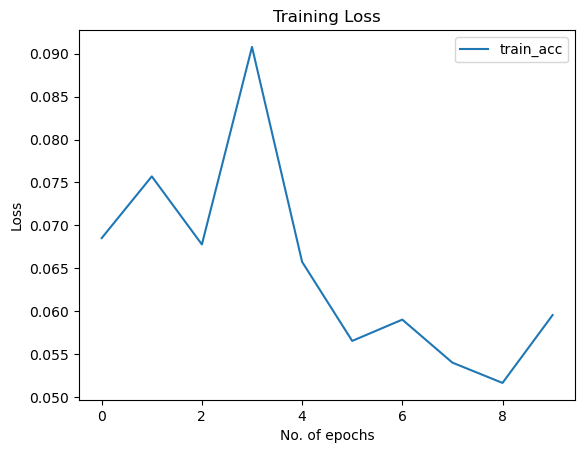

In [50]:
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label = 'train_acc')
plt.legend()
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

2/2 [==============================] - 11s 4s/step


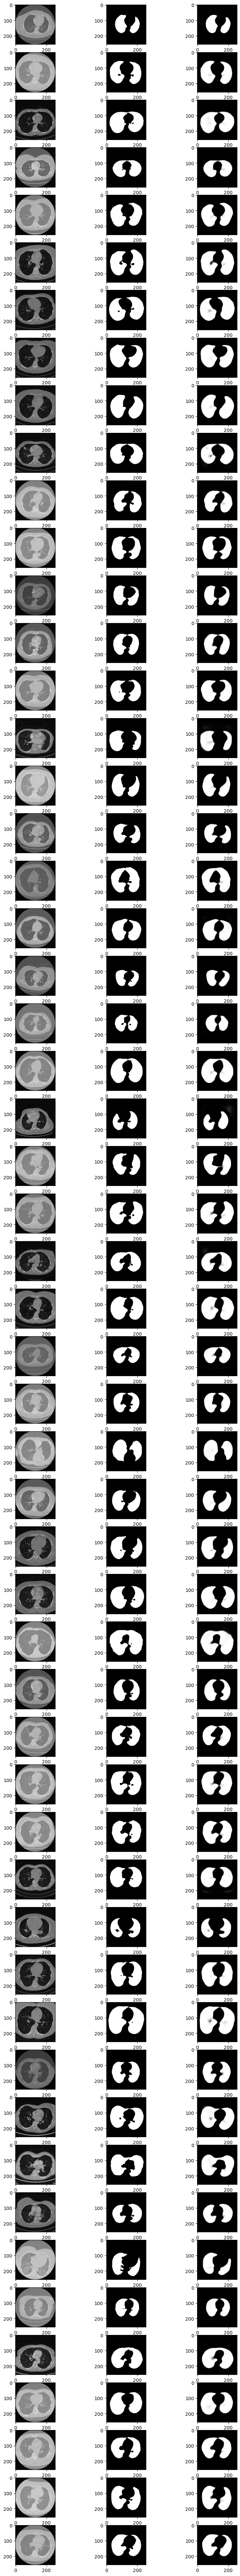

In [51]:
# predict segmentation
model.load_weights('C:/Users/BIKRAMJOY CHATTERJEE/DL Project/segmentation weights/att_unet_1.h5')
y_pred = model.predict(x_val)

# show results
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))
for i, pred in enumerate(y_pred):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

mean IoU =  0.38774323
acc =  0.989038
Dice Coefficient: 0.97738016
Classification Report : 
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99   2683736
       Lungs       0.97      0.98      0.98    855208

    accuracy                           0.99   3538944
   macro avg       0.98      0.99      0.99   3538944
weighted avg       0.99      0.99      0.99   3538944

Cohen's Kappa =  0.9701463933821951


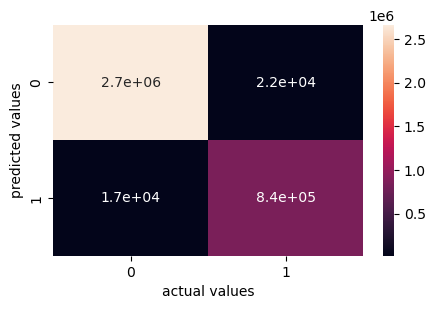

In [52]:
y_val_int = np.squeeze(y_val).astype(np.int32)
y_pred_int = np.squeeze(y_pred).astype(np.int32)

#MeanIoU
meaniou = MeanIoU(2)
meaniou.update_state(y_val_int, y_pred_int)
print('mean IoU = ', meaniou.result().numpy())
meaniou.reset_states()

y_val_binary = np.where(y_val > 0.5, 1, 0)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

#Accuracy
acc = Accuracy()
acc.update_state(y_val_binary, y_pred_binary)
print('acc = ', acc.result().numpy())
acc.reset_states()

#diceCoeff
intersection = tf.reduce_sum(tf.cast(y_val_binary * y_pred_binary, tf.float32))
sum_true = tf.reduce_sum(tf.cast(y_val_binary, tf.float32))
sum_pred = tf.reduce_sum(tf.cast(y_pred_binary, tf.float32))

dice_coeff = (2.0 * intersection + 1e-5) / (sum_true + sum_pred + 1e-5)
print("Dice Coefficient:", dice_coeff.numpy())

#Confusion matrix
cm = confusion_matrix(y_val_binary.flatten(), y_pred_binary.flatten(), labels=[0, 1])
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.xlabel('actual values')
plt.ylabel('predicted values')

#Classification report
cr = classification_report(y_val_binary.flatten(), y_pred_binary.flatten(), target_names=["Background", "Lungs"])
print("Classification Report : ")
print(cr)

#Cohen kappa score
k = cohen_kappa_score(y_val_binary.flatten(), y_pred_binary.flatten())
print("Cohen's Kappa = ", k)

In [53]:
# Calculate Parameters
params = model.count_params()
print("Total Parameters:", params)

# Calculate FLOPs
from keras_flops import get_flops

flops = get_flops(model, batch_size=1)
print("Estimated FLOPs:", flops)

Total Parameters: 7391939
Estimated FLOPs: 24091628552
